# 06 — Model Evaluation & Backtesting
Systematic evaluation using walk-forward validation across multiple horizons.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from src.data_loader import fetch_multiple_stocks
from src.baselines import NaiveForecast, RandomWalkForecast, SMAForecast, ARIMAForecast
from src.evaluation import backtest_model, compare_models, walk_forward_split, compute_all_metrics, plot_model_comparison_heatmap, plot_metrics_bar_chart, statistical_test

warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
SELECTED_TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "JPM", "V", "MA", "GS", "JNJ", "UNH", "LLY", "MRK", "ABBV", "XOM", "CVX", "PG", "KO", "PEP", "WMT", "HD", "CRM", "AMD", "NFLX", "DIS", "INTC", "BA", "GE"]

stock_data = fetch_multiple_stocks(SELECTED_TICKERS, period="2y")
sample_ticker = "AAPL"
series = stock_data[sample_ticker]["Close"]

print(f"Stock data loaded: {len(stock_data)} tickers")
print(f"Sample series shape: {series.shape}")

Fetching stock data:   0%|          | 0/30 [00:00<?, ?it/s]

Fetching stock data:   3%|▎         | 1/30 [00:00<00:02,  9.90it/s]

Fetching stock data: 100%|██████████| 30/30 [00:00<00:00, 221.73it/s]

Successfully loaded data for 30/30 tickers
Stock data loaded: 30 tickers
Sample series shape: (502,)


## 2. Walk-Forward Validation Splits

In [3]:
splits = walk_forward_split(series, n_windows=5)

print(f"Number of splits: {len(splits)}")
for i, (train_split, test_split) in enumerate(splits):
    print(f"Split {i}: Train [{train_split.index[0].date()} to {train_split.index[-1].date()}] ({len(train_split)} pts), "
          f"Test [{test_split.index[0].date()} to {test_split.index[-1].date()}] ({len(test_split)} pts)")

Number of splits: 5
Split 0: Train [2024-02-26 to 2025-10-01] (402 pts), Test [2025-10-02 to 2025-10-29] (20 pts)
Split 1: Train [2024-02-26 to 2025-10-29] (422 pts), Test [2025-10-30 to 2025-11-26] (20 pts)
Split 2: Train [2024-02-26 to 2025-11-26] (442 pts), Test [2025-11-28 to 2025-12-26] (20 pts)
Split 3: Train [2024-02-26 to 2025-12-26] (462 pts), Test [2025-12-29 to 2026-01-27] (20 pts)
Split 4: Train [2024-02-26 to 2026-01-27] (482 pts), Test [2026-01-28 to 2026-02-25] (20 pts)


## 3. Backtest All Models

In [4]:
model_configs = {
    "Naive": (NaiveForecast, {}),
    "Random Walk": (RandomWalkForecast, {}),
    "SMA(20)": (SMAForecast, {"window": 20}),
    "ARIMA": (ARIMAForecast, {})
}

backtest_results = {}

for model_name, (ModelClass, kwargs) in model_configs.items():
    result = backtest_model(series, ModelClass, model_params=kwargs, n_windows=5)
    backtest_results[model_name] = result
    print(f"{model_name}: {result.shape}")

Naive: (15, 7)
Random Walk: (15, 7)
SMA(20): (15, 7)


ARIMA: (15, 7)


## 4. Compare Models

In [5]:
summary = compare_models(backtest_results)
print(summary.to_string())

                     RMSE_mean  RMSE_std  MAE_mean  MAE_std  MAPE_mean  MAPE_std  DirAcc_mean  DirAcc_std
Model       Horizon                                                                                      
ARIMA       1d          1.7078    0.8210    1.7078   0.8210     0.6446    0.3179          NaN         NaN
            1m          8.8443    5.0729    7.3938   4.4368     2.8036    1.7468      53.6842      9.4150
            1w          4.2388    2.8985    3.4656   2.2611     1.2731    0.8060      55.0000     20.9165
Naive       1d          1.3721    0.5993    1.3721   0.5993     0.5182    0.2347          NaN         NaN
            1m          8.5723    5.1671    7.1436   4.5316     2.7136    1.7879       0.0000      0.0000
            1w          3.7700    2.6605    2.9935   2.0081     1.1011    0.7206       0.0000      0.0000
Random Walk 1d          1.7905    1.4097    1.7905   1.4097     0.6773    0.5549          NaN         NaN
            1m         18.4050    5.4269   15.

## 5. Visualize Model Comparison

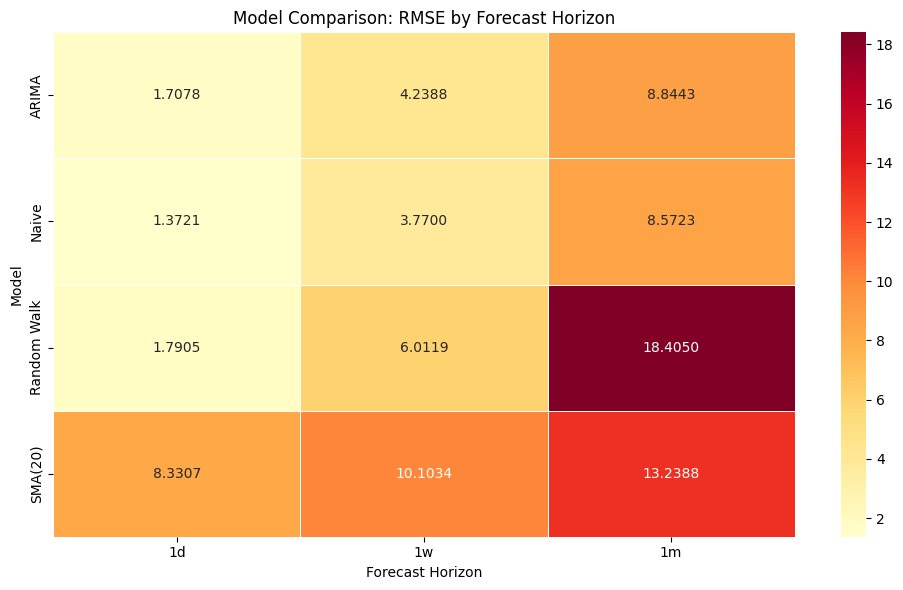

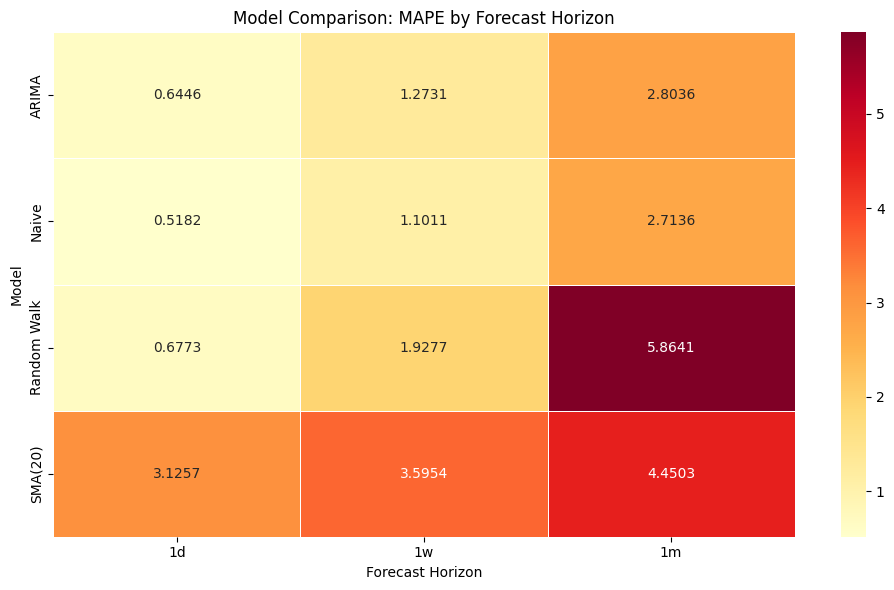

In [6]:
try:
    plot_model_comparison_heatmap(summary, metric="RMSE_mean", save=True, filename="06_model_comparison_rmse.png")
    plot_model_comparison_heatmap(summary, metric="MAPE_mean", save=True, filename="06_model_comparison_mape.png")
except Exception as e:
    print(f"Error creating heatmaps: {e}")

## 6. Metrics Bar Charts

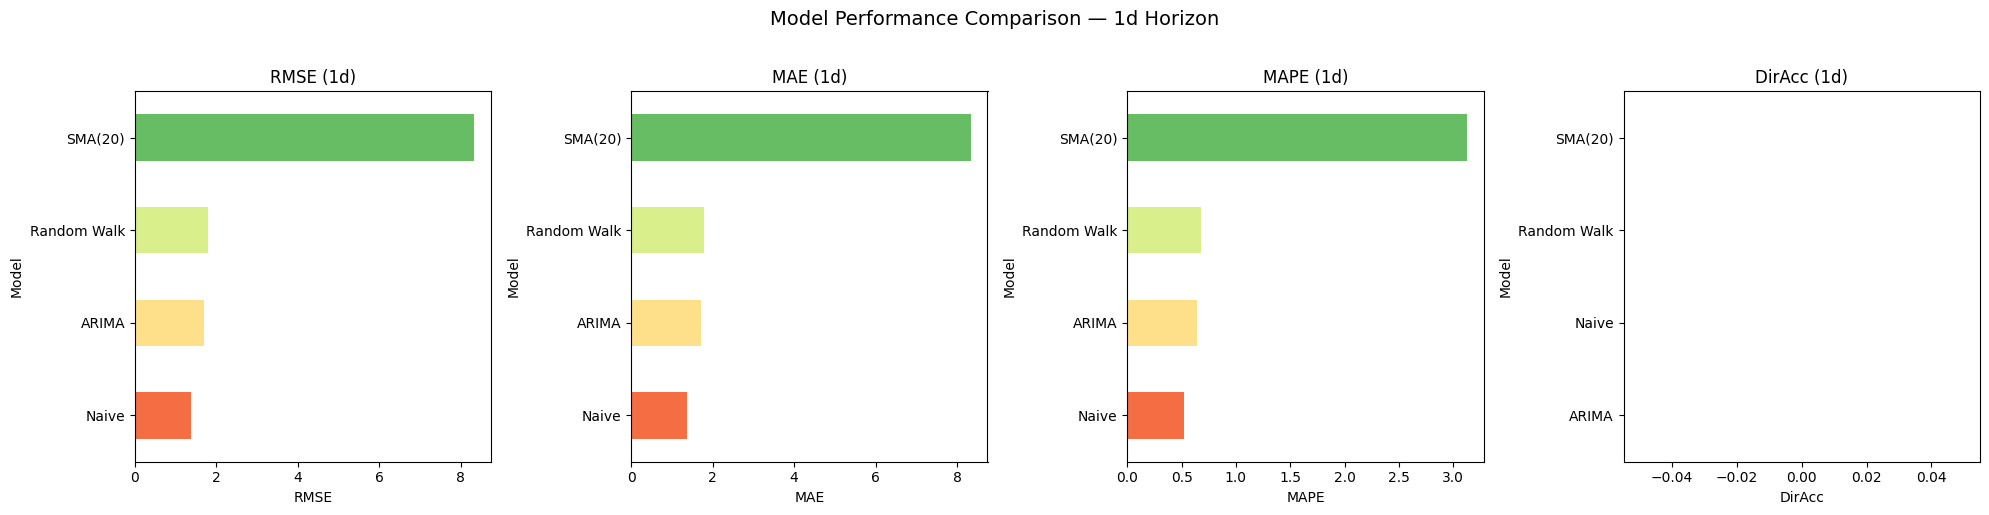

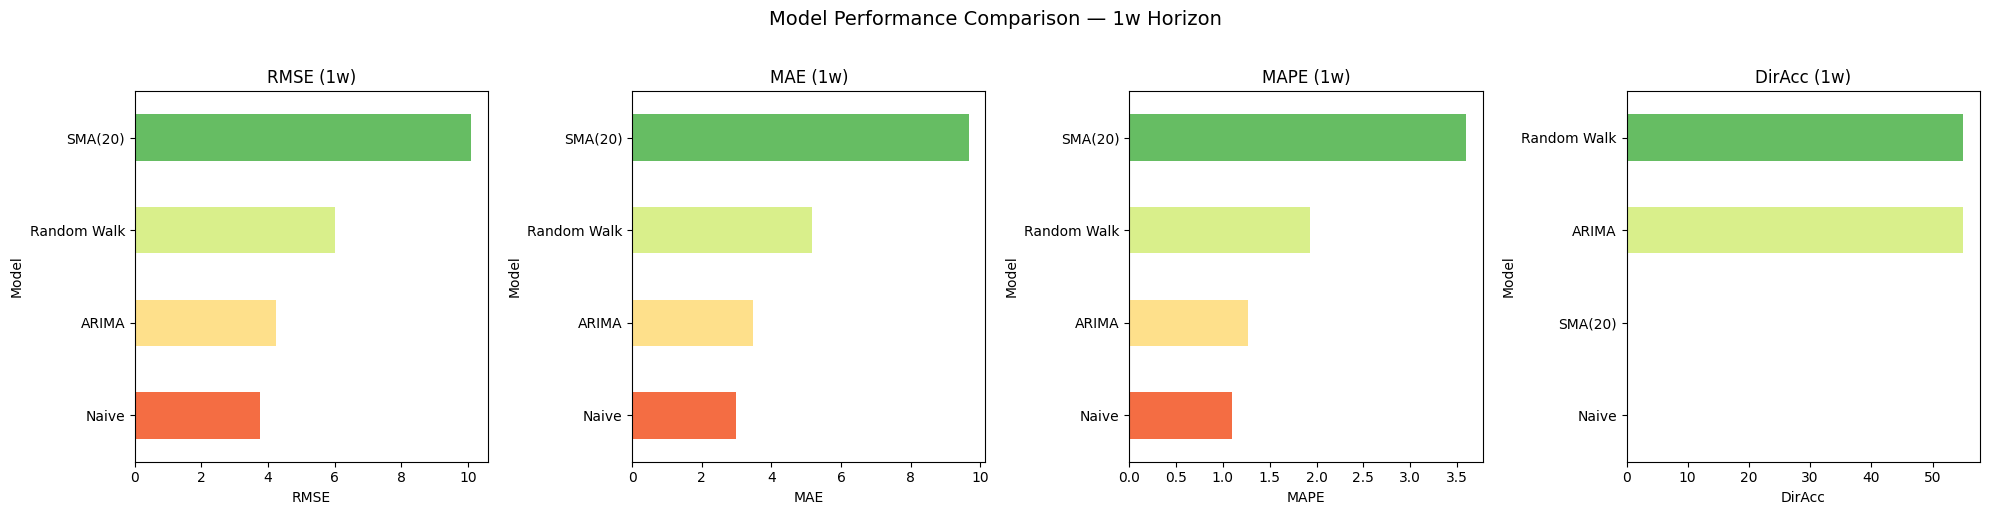

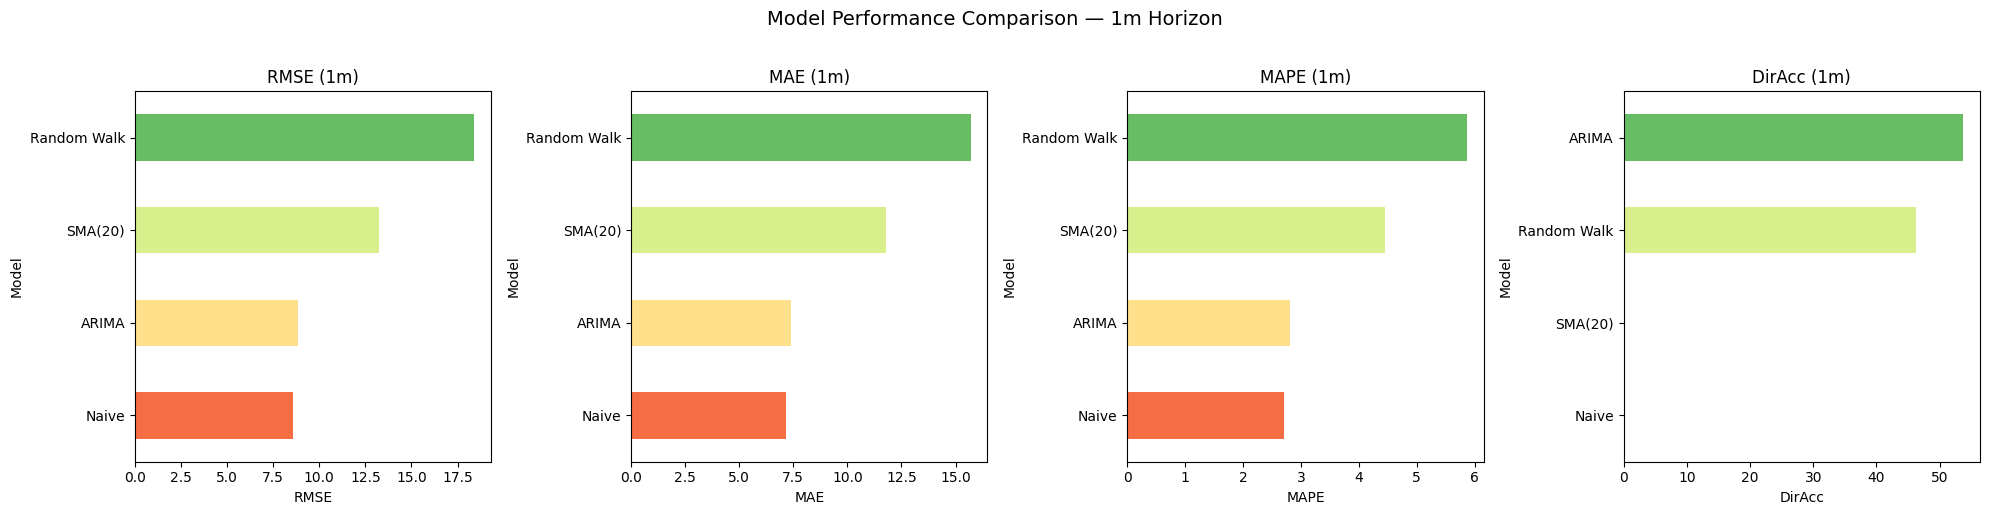

In [7]:
for horizon in ["1d", "1w", "1m"]:
    try:
        plot_metrics_bar_chart(summary, horizon=horizon, save=True, filename=f"06_metrics_{horizon}.png")
    except Exception as e:
        print(f"Skipping {horizon}: {e}")

## 7. Statistical Significance Tests

In [8]:
# Statistical significance: compare forecast errors from backtests
model_pairs = [('Naive', 'ARIMA'), ('Random Walk', 'ARIMA'), ('SMA(20)', 'ARIMA')]
stat_results = []

for model1, model2 in model_pairs:
    try:
        errors1 = backtest_results[model1]['RMSE'].values
        errors2 = backtest_results[model2]['RMSE'].values
        result = statistical_test(errors1, errors2)
        result['Model 1'] = model1
        result['Model 2'] = model2
        stat_results.append(result)
    except Exception as e:
        print(f"Error comparing {model1} vs {model2}: {e}")

if stat_results:
    stat_df = pd.DataFrame(stat_results)
    print(stat_df.to_string())
else:
    print("No statistical tests completed")

   statistic   p_value  significant      Model 1 Model 2
0  -2.031130  0.061678        False        Naive   ARIMA
1   2.018316  0.063141        False  Random Walk   ARIMA
2   4.075391  0.001135         True      SMA(20)   ARIMA


## 8. Multi-Stock Evaluation

In [9]:
multi_ticker_results = []
eval_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

for ticker in eval_tickers:
    if ticker not in stock_data:
        continue
    t_series = stock_data[ticker]["Close"]
    
    naive_result = backtest_model(t_series, NaiveForecast, n_windows=3)
    arima_result = backtest_model(t_series, ARIMAForecast, n_windows=3)
    
    multi_ticker_results.append({
        'ticker': ticker,
        'naive_rmse_mean': naive_result['RMSE'].mean(),
        'arima_rmse_mean': arima_result['RMSE'].mean(),
        'naive_mape_mean': naive_result['MAPE'].mean(),
        'arima_mape_mean': arima_result['MAPE'].mean(),
    })

multi_ticker_df = pd.DataFrame(multi_ticker_results)
print(multi_ticker_df.to_string())

  ticker  naive_rmse_mean  arima_rmse_mean  naive_mape_mean  arima_mape_mean
0   AAPL         4.371989         4.311290         1.373596         1.381004
1   MSFT        13.028567        13.071006         2.382963         2.388418
2  GOOGL        11.822162        11.872096         3.356898         3.370959
3   AMZN         4.751379         4.805637         1.700709         1.733514
4   NVDA         4.428666         4.352954         2.108886         2.022509


## 9. Save Evaluation Results

In [10]:
summary.to_parquet("../data/processed/evaluation_summary.parquet")
if multi_ticker_results:
    multi_ticker_df.to_parquet("../data/processed/multi_ticker_evaluation.parquet")

print("Evaluation results saved.")

Evaluation results saved.
